In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, collections, itertools, math, functools, sys, sklearn
import stanity

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0, plusminus=False):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    diff = (bars[1] - bars[0]) / 2
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2))
        diff = round_to_n(diff, 1)
    if plusminus:
        return (pattern + " $\\pm$ " + pattern) % (numpy.mean(values), diff)
    return (pattern + " (" + pattern + "-" + pattern + ")") % ((numpy.mean(values),) + bars)
pandas.set_option('display.max_columns', 500)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [11]:
df = pandas.read_csv("../data/derived/sources.extended.csv", index_col="source_id")
df = df.ix[~pandas.isnull(df.mutations)]
df["percentage_cellularity"] = df["percentage_cellularity_x"]
df

,Unnamed: 0,RNA_ID,RNA biospecimen,DNA_id,DNA_biospecimen,specimen_type_description,CollectionPoint,SpecimenType,RNA data file,DNA_sample_string,icgc_sample_id,project_code_x,submitted_sample_id,icgc_specimen_id,submitted_specimen_id_x,icgc_donor_id_x,submitted_donor_id_x,analyzed_sample_interval,percentage_cellularity_x,level_of_cellularity_x,study,project_code_y,study_specimen_involved_in,submitted_specimen_id_y,icgc_donor_id_y,submitted_donor_id_y,specimen_type,specimen_type_other,specimen_interval,specimen_donor_treatment_type,specimen_donor_treatment_type_other,specimen_processing,specimen_storage,tumour_confirmed,tumour_histological_type,tumour_grading_system,tumour_grade,tumour_stage_system,tumour_stage,percentage_cellularity_y,level_of_cellularity_y,cohort,donor,tissue_type,timepoint,treated,metastasis,interval_days,bam_path_tumor_dna,bam_path_tumor_rna,timepoint_paired,protein changing,peptides,expressed peptides,mutations,mutations_per_mb,indel,group,treatment,specific_treatment,fraction_peptides_expressed,percent_peptides_expressed,percentage_cellularity
source_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AOCS-001-1-7,0,ICGCDBDE20130916001,AOCS-001-2-0,AOCS_001_ICGC_DBPC_20130205_002,AOCS-001-1-7,primary tumour,Primary,Tumour,130906_D81P8DQ1_0153_C2704ACXX.nopd.AOCS_001_I...,ICGCDBPC20130205002,SA505244,OV-AU,AOCS-001-1-7,SP101515,AOCS-001-1,DO46325,AOCS-001,1895.0,73.0,61-80%,PCAWG,OV-AU,PCAWG,AOCS-001-1,DO46325,AOCS-001,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3.0,FIGO,III,73.0,61-80%,AOCS,AOCS-001,solid,primary,False,False,0,/demeter/scratch/datasets/ega-tim/EGAZ00001018...,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,False,47,122,71,5746,1.914057,1.0,AOCS solid,treatment naive,treatment naive,0.581967,58.196721,73.0
AOCS-004-1-5,1,ICGCDBDE20130916003,AOCS-004-2-9,AOCS_004_ICGC_DBPC_20130205_004,AOCS-004-1-5,primary tumour,Primary,Tumour,130906_D81P8DQ1_0157_C270DACXX.nopd.AOCS_004_I...,ICGCDBPC20130205004,SA505270,OV-AU,AOCS-004-1-5,SP101519,AOCS-004-1,DO46327,AOCS-004,1350.0,77.0,61-80%,PCAWG,OV-AU,PCAWG,AOCS-004-1,DO46327,AOCS-004,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3.0,FIGO,III,77.0,61-80%,AOCS,AOCS-004,solid,primary,False,False,0,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,False,57,58,20,6647,2.214191,2.0,AOCS solid,treatment naive,treatment naive,0.344828,34.482759,77.0
AOCS-005-1-8,2,ICGCDBDE20130916004,AOCS-005-2-1,AOCS_005_ICGC_DBPC_20130205_006,AOCS-005-1-8,primary tumour,Primary,Tumour,130906_D81P8DQ1_0157_C270DACXX.nopd.AOCS_005_I...,ICGCDBPC20130205006,SA505282,OV-AU,AOCS-005-1-8,SP101521,AOCS-005-1,DO46328,AOCS-005,2128.0,90.0,>81%,PCAWG,OV-AU,PCAWG,AOCS-005-1,DO46328,AOCS-005,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8441/3,Silverberg,3.0,FIGO,III,90.0,>81%,AOCS,AOCS-005,solid,primary,False,False,0,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,False,38,60,36,5613,1.869753,2.0,AOCS solid,treatment naive,treatment naive,0.600000,60.000000,90.0
AOCS-034-1-0,3,ICGCDBLG2010050402TR,AOCS-034-2-4,AOCS_034_ICGC_DBPC_20130205_009,AOCS-034-1-0,primary tumour,Primary,Tumour,131206_EXTERN_0045_AC2KJBACXX.nopd.AOCS_034_IC...,ICGCDBPC20130205009,SA505297,OV-AU,AOCS-034-1-0,SP101523,AOCS-034-1,DO46329,AOCS-034,1953.0,84.0,>81%,PCAWG,OV-AU,PCAWG,AOCS-034-1,DO46329,AOCS-034,Primary tumour - solid tissue,NaN,0,no treatment,NaN,fresh,"frozen, vapor phase",no,8140/3,Silverberg,3.0,FIGO,III,84.0,>81%,AOCS,AOCS-034,solid,primary,False,False,0,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,/demeter/scratch/datasets/ega-tim/_EGAZ0000101...,True,72,167,59,6915,2.303464,5.0,AOCS solid,treatment naive,treatment naive,0.353293,35.329341,84.0
AOCS-034-3-8,4,ICGCDBDE20131122024,AOCS-034-4-1,AOCS_034_ICGC_DBPC_20130205_007,AOC

In [12]:
predicted = ["mutations", "peptides", "expressed peptides"]

# donor is handled specially
predictors = [
    "treated",
#    "timepoint",
#    "metastasis",
#    "specimen_interval",
    "tissue_type",
#    "tumour_grade",
#    "tumour_stage",
    "percentage_cellularity"
]

In [13]:
def make_data(y_column):
    stan_df = df[[y_column, "donor"] + predictors].copy()
    stan_df.columns = ["y"] + list(stan_df.columns[1:])
    stan_df["y"] = numpy.log(stan_df["y"])
    original_donors = stan_df.donor
    stan_df["low_cellularity"] = stan_df.percentage_cellularity < stan_df.dropna().percentage_cellularity.quantile(.25)
    del stan_df["percentage_cellularity"]
    stan_df["ascites"] = stan_df["tissue_type"] == "ascites"
    del stan_df["tissue_type"]
    stan_df["num_sources_for_donor"] = pandas.Series(
        [(original_donors == donor).sum() for donor in original_donors],
        index=original_donors.index)

    stan_df = stan_df.dropna()
    stan_df["donor"] = stan_df.donor.astype('category').values.codes
    stan_df["solid and treated"] = (~stan_df.ascites) & (stan_df.treated)
    return stan_df

data_by_predicted = collections.OrderedDict()
for col in predicted:
    data_by_predicted[col] = make_data(col)
    print(col, data_by_predicted[col].shape)
data_by_predicted["mutations"]  

mutations (114, 7)
peptides (114, 7)
expressed peptides (114, 7)


,y,donor,treated,low_cellularity,ascites,num_sources_for_donor,solid and treated
source_id,,,,,,,
AOCS-001-1-7,8.656259,0,False,True,False,1,False
AOCS-004-1-5,8.801921,1,False,False,False,1,False
AOCS-005-1-8,8.632841,2,False,False,False,1,False
AOCS-034-1-0,8.841448,3,False,False,False,2,False
AOCS-034-3-8,9.490771,3,True,False,True,2,False
AOCS-055-1-7,9.591923,4,False,False,False,1,False
AOCS-056-1-X,8.847647,5,False,False,False,1,False
AOCS-057-1-2,8.701180,6,False,True,False,1,False
AOCS-058-1-5,9.101529,7,False,False,False,1,False


In [14]:
# stan model
model1 = """
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_predictors;
    int<lower=0> num_donors;

    // Data
    vector[num_predictors] predictors[num_sources];
    int<lower=0> donors[num_sources];
    real y[num_sources];  // predicted variable
    int<lower=1> num_sources_for_donor[num_sources];
}
parameters {
    real global_mean;
    real<lower=0> donor_sigma;
    real<lower=0> sample_sigma;
    vector[num_donors] donor_mean;    
    vector[num_predictors] predictor_coefficients;
}
transformed parameters {
    real lp;
    real mu[num_sources];
    
    for (i in 1:num_sources) {
        lp <- dot_product(predictors[i], predictor_coefficients);
        if (num_sources_for_donor[i] > 1) {
            mu[i] <- donor_mean[donors[i]] + lp;
        } else {
            mu[i] <- global_mean + lp;
        }
    }
}
model {
    global_mean ~ normal(0, 100);
    donor_sigma ~ cauchy(0, 2);
    sample_sigma ~ cauchy(0, 2);
    donor_mean ~ normal(global_mean, donor_sigma);
    predictor_coefficients ~ normal(0, 20);
    y ~ normal(mu, sample_sigma);    
}
generated quantities {
    real y_rep[num_sources];
    real log_lik[num_sources];
    
    for (i in 1:num_sources) {
        // not sure if these are vectorized
        y_rep[i] <- normal_rng(mu[i], sample_sigma);
        log_lik[i] <- normal_log(y[i], mu[i], sample_sigma);
    }
}
""".strip()

data = {    

}
def init(data):
    return {
        'global_mean': 0.0,
        'donor_sigma': 1.0,
        'sample_sigma': 1.0,
        'donor_mean': numpy.zeros(data['num_donors']),
        'predictor_coefficients': numpy.random.normal(0, .1, size=(data['num_predictors'],)),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (y_label, raw_data) in data_by_predicted.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % y_label)
    df_x = raw_data[[x for x in list(raw_data.columns) if x not in ("y", "donor")]].astype(float)
    data = {
        'num_sources': len(raw_data.index),
        'num_predictors': len(df_x.columns),
        'num_donors': raw_data.donor.nunique(),
        'predictors': df_x.values.astype(float),
        'donors': raw_data.donor.values + 1,  # convert to 1-indexed
        'num_sources_for_donor': raw_data.num_sources_for_donor.values,
        'y': raw_data.y.values,
    }
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[y_label] = stanity.fit(model_code=model1, data=data, init=lambda: init(data), iter=10000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_predictors;
  5     int<lower=0> num_donors;
  6 
  7     // Data
  8     vector[num_predictors] predictors[num_sources];
  9     int<lower=0> donors[num_sources];
 10     real y[num_sources];  // predicted variable
 11     int<lower=1> num_sources_for_donor[num_sources];
 12 }
 13 parameters {
 14     real global_mean;
 15     real<lower=0> donor_sigma;
 16     real<lower=0> sample_sigma;
 17     vector[num_donors] donor_mean;    
 18     vector[num_predictors] predictor_coefficients;
 19 }
 20 transformed parameters {
 21     real lp;
 22     real mu[num_sources];
 23     
 24     for (i in 1:num_sources) {
 25         lp <- dot_product(predictors[i], predictor_coefficients);
 26         if (num_sources_for_donor[i] > 1) {
 27             mu[i] <- donor_mean[donors[i]] + lp;
 28         } else {
 29             mu[i] <- global_mean + lp;
 30         }
 31     }
 32 }
 33 model {
 34     global

In [15]:
all_fit_coefficients = []
for (y_label, fit) in fit_results.items():
    extracted = fit.extract()
    fit_coefficients = pandas.DataFrame(numpy.exp(extracted['predictor_coefficients']),
                           columns=list(data_by_predicted[y_label].columns)[2:])
    fit_coefficients["y_label"] = y_label
    all_fit_coefficients.append(fit_coefficients)
all_fit_coefficients = pandas.concat(all_fit_coefficients, ignore_index=True)
all_fit_coefficients.to_csv("../data/bayesian_model_fit_coefficients.csv", index=False)
all_fit_coefficients

,treated,low_cellularity,ascites,num_sources_for_donor,solid and treated,y_label
0,2.134838,0.769952,0.891767,1.170772,0.388303,peptides
1,1.055297,1.013706,1.566877,1.452251,1.153012,peptides
2,1.841871,0.992087,0.846363,1.656234,0.626197,peptides
3,0.770320,1.002625,2.019886,1.276903,1.803918,peptides
4,2.310566,0.910105,0.799079,1.360368,0.479783,peptides
5,2.148948,1.000160,0.707247,1.503320,0.602304,peptides
6,2.108349,0.997501,0.988732,1.425656,0.550039,peptides
7,1.072911,1.111685,1.967904,1.075721,1.438420,peptides
8,1.437127,1.090950,1.631029,1.382299,1.038176,peptides
9,0.679438,1.227118,1.790570,1.621999,1.657424,peptides


#### plot coefficient values by outcome type

In [16]:
melted = pandas.melt(all_fit_coefficients, id_vars=["y_label"])

In [17]:
all_fit_coefficients.columns

Index(['treated', 'low_cellularity', 'ascites', 'num_sources_for_donor',
       'solid and treated', 'y_label'],
      dtype='object')

In [18]:
# STATEMENT_TREATMENT_EFFECT

treatment_effect = (all_fit_coefficients.ix[all_fit_coefficients.y_label == "mutations"].treated - 1) * 100

print("found the treated samples had %f (95 credible region %f--%f) more somatic mutations"
      % (treatment_effect.mean(), treatment_effect.quantile(.05),treatment_effect.quantile(.95)))
print("with a %f posterior probability that post-treatment timepoint was associated with at least a 5 percent increase in mutations." %
      (treatment_effect > 1.05).mean())

treatment_effect = (all_fit_coefficients.ix[all_fit_coefficients.y_label == "peptides"].treated - 1) * 100

print("found the treated samples had %f (95 credible region %f--%f) more neoantigens"
      % (treatment_effect.mean(), treatment_effect.quantile(.05),treatment_effect.quantile(.95)))

treatment_effect = (all_fit_coefficients.ix[all_fit_coefficients.y_label == "expressed peptides"].treated - 1) * 100

print("found the treated samples had %f (95 credible region %f--%f) more expressed neoantigens"
      % (treatment_effect.mean(), treatment_effect.quantile(.05),treatment_effect.quantile(.95)))

treatment_effect = (
    all_fit_coefficients.ix[all_fit_coefficients.y_label == "expressed peptides"].treated *
    all_fit_coefficients.ix[all_fit_coefficients.y_label == "expressed peptides"]["solid and treated"] - 1) * 100

print("but solid tumors had %f (95 credible region %f--%f) more expressed neoantigens"
      % (treatment_effect.mean(), treatment_effect.quantile(.05),treatment_effect.quantile(.95)))


found the treated samples had 50.823574 (95 credible region 0.244285--116.173558) more somatic mutations
with a 0.946400 posterior probability that post-treatment timepoint was associated with at least a 5 percent increase in mutations.
found the treated samples had 70.805017 (95 credible region -14.654488--193.482320) more neoantigens
found the treated samples had 124.490732 (95 credible region 2.737122--311.179049) more expressed neoantigens
but solid tumors had -21.589560 (95 credible region -51.475594--18.118823) more expressed neoantigens


In [19]:
'''
nice_melted = melted.copy()
nice_melted.variable = nice_melted.variable.map(lambda x: {
        "low_cellularity": "low purity",
        "num_sources_for_donor": "donor sample count"
}.get(x, x))
renames = {
    'treated': 'treated vs. untreated',
    'solid': 'solid vs. ascites tumor',
    'low purity': 'low vs. high purity',
    'solid and treated': 'interaction:\nsolid tumor + treated',
    'donor sample count': 'donor sample count',
}
nice_melted.variable = nice_melted.variable.map(renames)

seaborn.set_context('paper')
seaborn.set_style("whitegrid")
seaborn.boxplot(
    data=nice_melted,
    y='variable',
    x='value',
    hue='y_label',
    order=[renames.get(x, x) for x in ["treated", "solid", "low purity", "solid and treated", "donor sample count"]],
    hue_order=["mutations", "peptides", "expressed peptides"],
    whis=[5, 95],
    orient='h',
    showbox=True,
    showfliers=False,
#    meanline=True,
#    showmeans=True
)
pyplot.xlim(xmin=0,xmax=3)
pyplot.ylabel("")
pyplot.xlabel("Fold change")
pyplot.legend(title=None, loc='lower right')
pyplot.axvline(1.0, color="black")
pyplot.tight_layout()
pyplot.savefig("../figures/bayesian_model_effects.pdf")
'''

'\nnice_melted = melted.copy()\nnice_melted.variable = nice_melted.variable.map(lambda x: {\n        "low_cellularity": "low purity",\n        "num_sources_for_donor": "donor sample count"\n}.get(x, x))\nrenames = {\n    \'treated\': \'treated vs. untreated\',\n    \'solid\': \'solid vs. ascites tumor\',\n    \'low purity\': \'low vs. high purity\',\n    \'solid and treated\': \'interaction:\nsolid tumor + treated\',\n    \'donor sample count\': \'donor sample count\',\n}\nnice_melted.variable = nice_melted.variable.map(renames)\n\nseaborn.set_context(\'paper\')\nseaborn.set_style("whitegrid")\nseaborn.boxplot(\n    data=nice_melted,\n    y=\'variable\',\n    x=\'value\',\n    hue=\'y_label\',\n    order=[renames.get(x, x) for x in ["treated", "solid", "low purity", "solid and treated", "donor sample count"]],\n    hue_order=["mutations", "peptides", "expressed peptides"],\n    whis=[5, 95],\n    orient=\'h\',\n    showbox=True,\n    showfliers=False,\n#    meanline=True,\n#    showmea

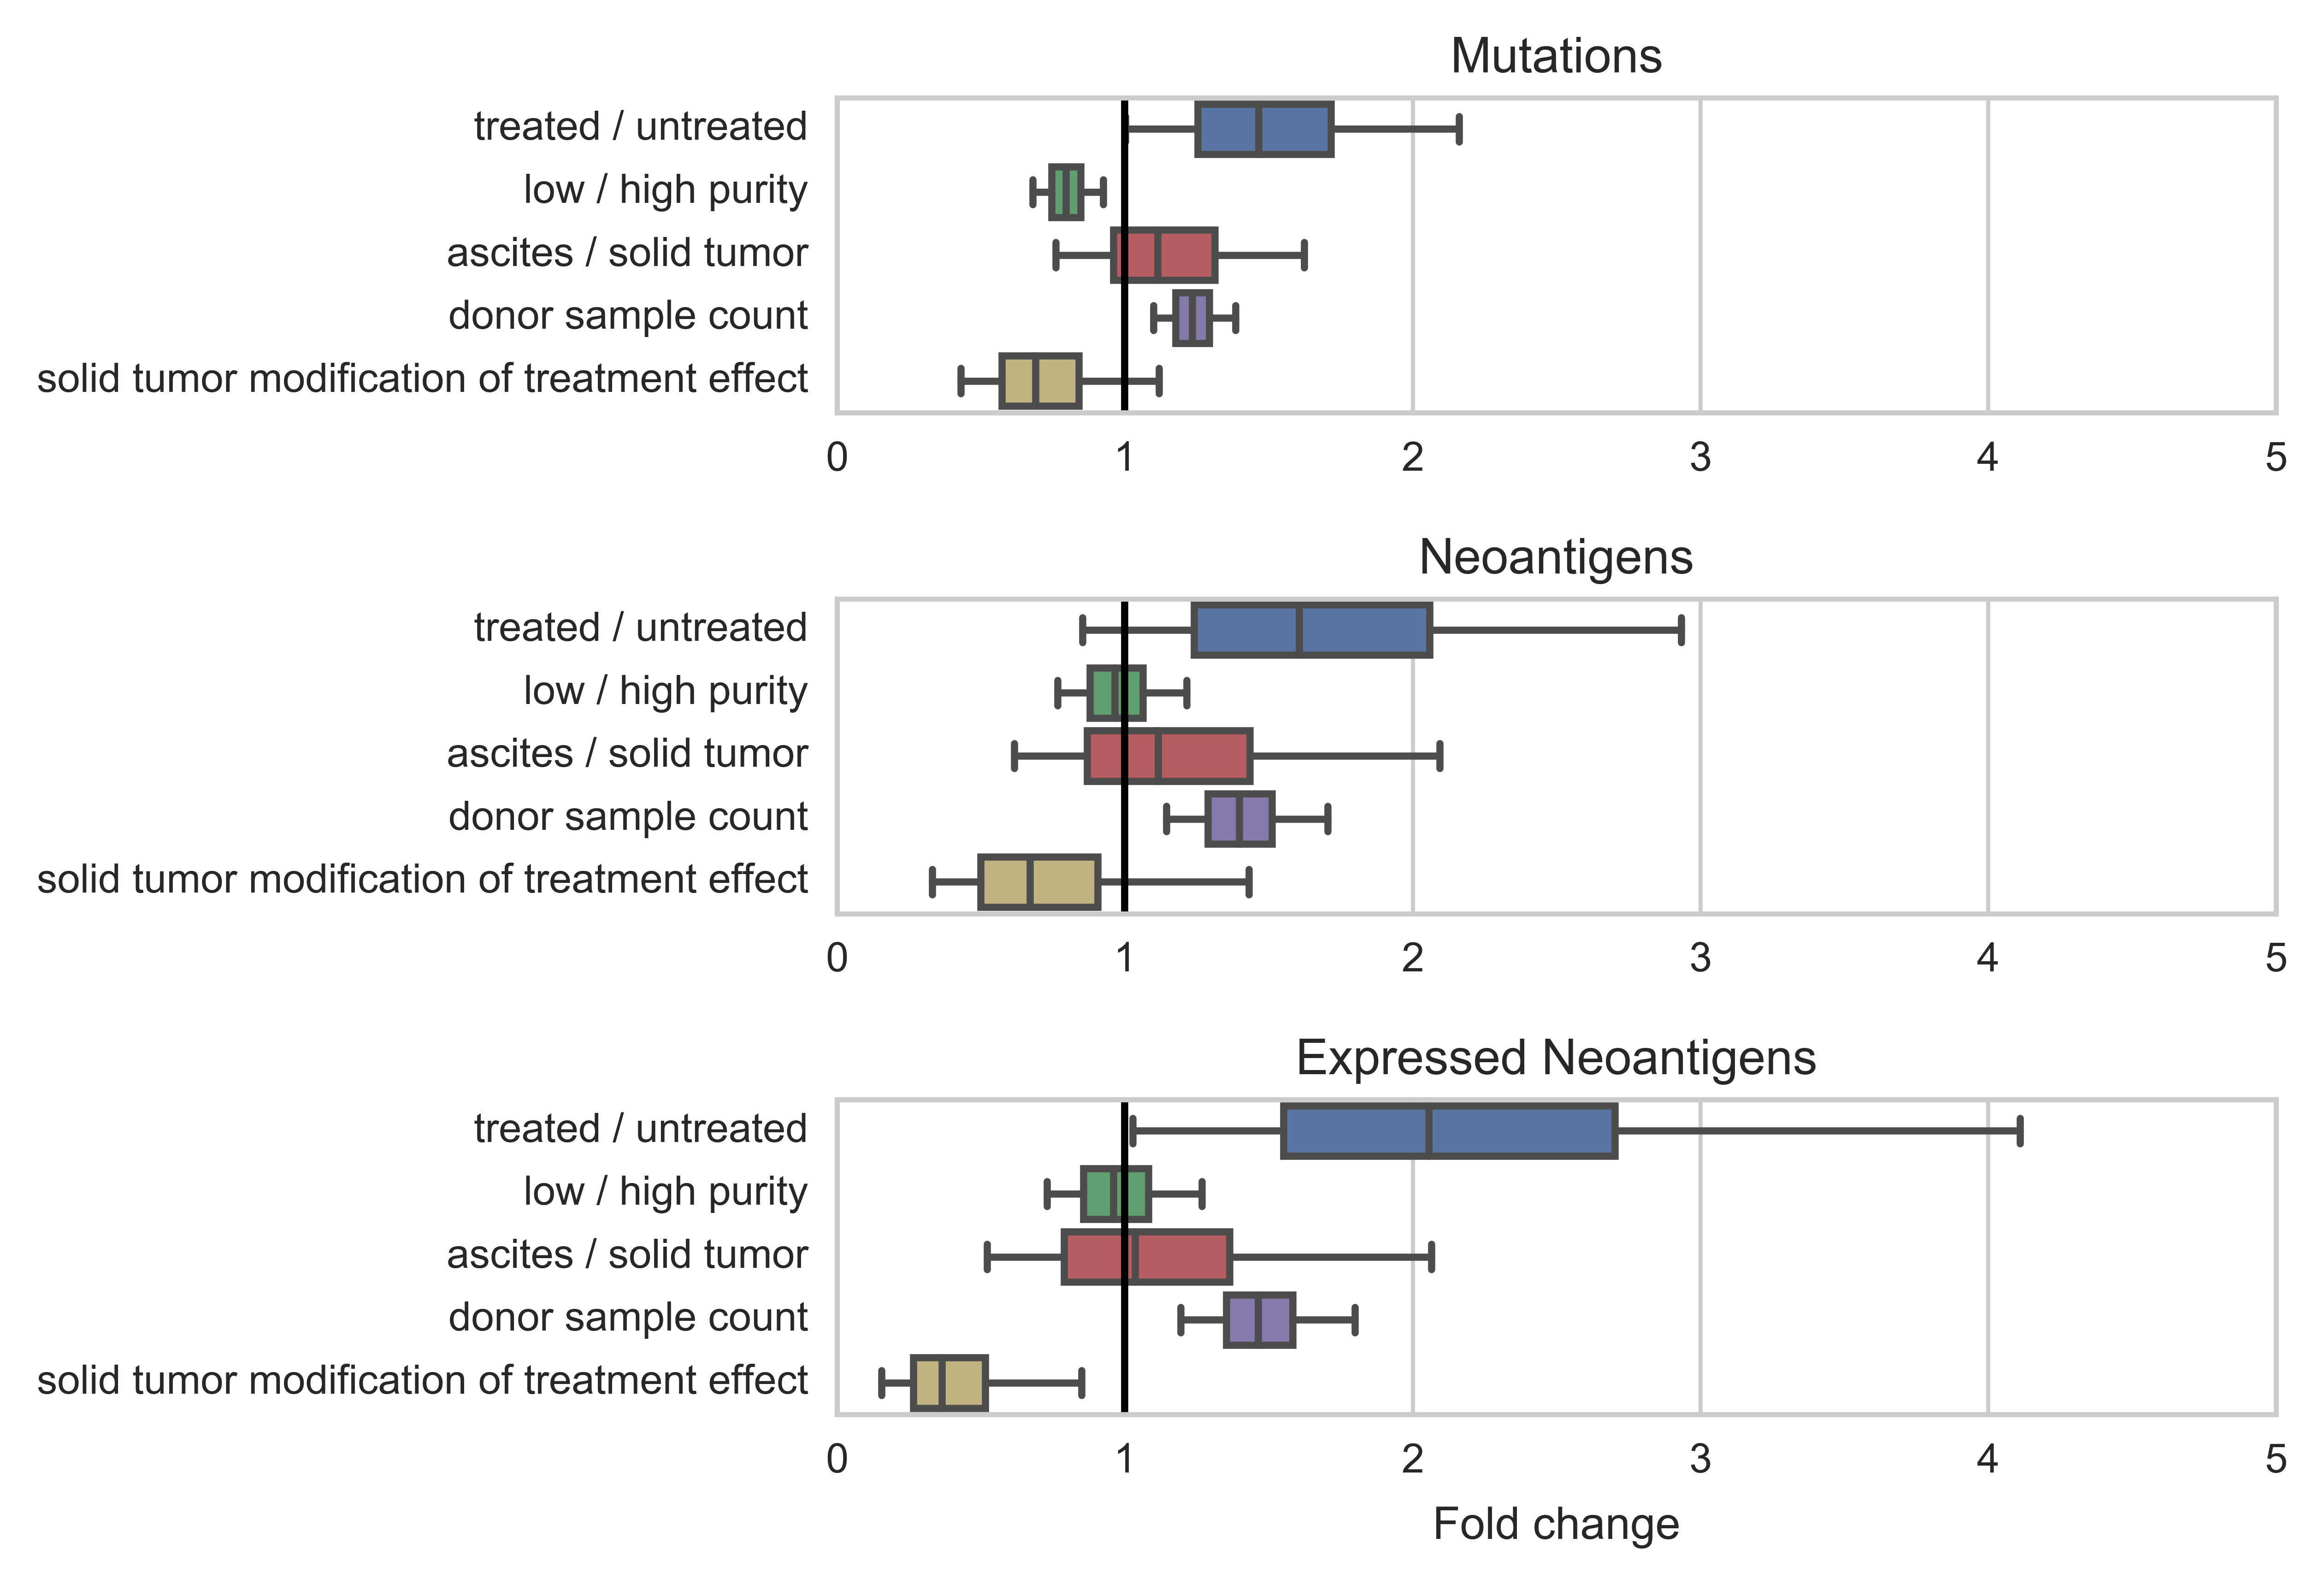

In [20]:
renames = {
    'treated': 'treated / untreated',
    'ascites': 'ascites / solid tumor',
    'low_cellularity': 'low / high purity',
    'solid and treated': 'solid tumor modification of treatment effect',
    'num_sources_for_donor': 'donor sample count',
    'recurrence': 'recurrence / primary',
}

seaborn.set_context('paper')
seaborn.set_style('whitegrid')
pyplot.figure()

titles_and_ylabels = [
    ("Mutations", "mutations"),
    ("Neoantigens", "peptides"),
    ("Expressed Neoantigens", "expressed peptides"),
]
rows = len(titles_and_ylabels)

ax = None
for (row, (title, y_label)) in enumerate(titles_and_ylabels):
    ax = pyplot.subplot(rows, 1, row + 1, sharex=ax)
    pyplot.title(title)
    sub_df = all_fit_coefficients[all_fit_coefficients.y_label == y_label].copy()
    sub_df.columns = [renames.get(c, c) for c in sub_df.columns]
    seaborn.boxplot(
        data=sub_df,
        orient="h",
        whis=[5, 95],
        showbox=True,
        showfliers=False)

    if row + 1 == rows:
        pyplot.xlabel("Fold change")
    pyplot.axvline(1.0, color="black")
    pyplot.xlim(xmin=0, xmax=5)

pyplot.tight_layout()
pyplot.savefig("../figures/bayesian_model_effects.pdf")


In [22]:
# Table 1
mutations = pandas.read_csv("../data/derived/annotated_mutations.with_mhc_binders.csv.bz2", converters={'binding_peptides': eval})
sources = pandas.read_csv("../data/derived/sources.extended.csv", index_col="source_id")


/Users/tim/miniconda3/envs/py3k/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
# For Table 1, we also need neoantigen etc counts. This was copied from the neoantigen counts notebook.

def mean_with_std(grouped_column, decimals=0):
    pattern = "%%0.%df" % decimals
    return [
        (pattern + " +/ " + pattern) % (m, s) if not pandas.isnull(s) else pattern % m
        for (m, s) in zip(grouped_column.mean(), grouped_column.std())
    ]

def means_with_errorbars(grouped_column, decimals=0, plusminus=False):
    index = []
    values = []
    for (i, grouped) in grouped_column:
        index.append(i)
        values.append(mean_with_errorbars(grouped, decimals=decimals, plusminus=plusminus))
    return pandas.Series(values, index=index)
    
samples_with_rna = mutations.source_id.ix[mutations.rna_total_reads > 0].unique()

#grouping_columns = ["cohort", "library", "tissue_type", "treated"]
grouping_columns = ["cohort", "tissue_type", "treated"]

grouped = sources.groupby(grouping_columns)

df = grouped.donor.nunique().to_frame() #.reset_index()
df["samples"] = grouped.donor.count().to_frame()["donor"]
df["samples with RNA"] = sources.ix[sources.index.isin(samples_with_rna)].groupby(grouping_columns).donor.count().to_frame()["donor"]
df["Mutations"] = means_with_errorbars(grouped.mutations, plusminus=True)
#df["C(C>A)C percent"] = means_with_errorbars(grouped["interesting mutations"], decimals=2)
#df["Protein changing"] = means_with_errorbars(grouped["protein changing"])
df["Neoantigens"] = means_with_errorbars(grouped.peptides, plusminus=True)
df["Expressed"] = means_with_errorbars(grouped["expressed peptides"], plusminus=True)


df = df.reset_index()
df["treated"] = df.treated.map({False: "untreated", True: "post-treatment"})
df["samples"] = ["%d (%d)" % (row.samples, row["samples with RNA"]) for (i, row) in df.iterrows()]
del df["samples with RNA"]
df = df.rename(columns={
        "donor": "donors",
        "treated": "treatment",
        "samples": "samples (RNA)",
        "tissue_type": "tissue type",
    })

#df.to_csv("../data/cohort.csv")
del df["cohort"]
#del df["library"]
df.index = ["%s %s" % (row["tissue type"], 'post-treatment' if row["treatment"] != 'untreated' else 'pre-treatment') for (i, row) in df.iterrows()]
del df["tissue type"]
del df["treatment"]
del df["donors"]
df = df.applymap(str)
df


def treatment_effect(y_label, solid):
    sub_df = all_fit_coefficients.ix[all_fit_coefficients.y_label == y_label]
    #if solid and y_label == "expressed peptides":
    if solid:
        effect = sub_df["treated"] * sub_df["solid and treated"]
    else:
        effect = sub_df["treated"]
    result = (effect - 1.0) * 100.0
    #return r"%.2f $\pm$ %0.2f" % (result.mean(), (result.std()) * 2)

    return r"%.0f $\pm$ %0.0f" % (result.mean(), (result.quantile(0.95) - result.quantile(0.05)) / 2)

df_with_model = pandas.concat([
    df,
    pandas.DataFrame({
            'Mutations': [treatment_effect("mutations", False), treatment_effect("mutations", True)],
            'Neoantigens': [treatment_effect("peptides", False), treatment_effect("peptides", True)],
            'Expressed': [treatment_effect("expressed peptides", False), treatment_effect("expressed peptides", True)],
            }, index=["ascites model-adjusted percent change", "solid model-adjusted percent change"])
], ignore_index=False).fillna('')[df.columns]
df_with_model = df_with_model.ix[sorted(df_with_model.index,
                                        key=lambda x: ('ascites' not in x, 'pre' not in x, 'post' not in x, 'effect' not in x))]

df_with_model.rename(columns={'Expressed': 'Expressed Neoantigens'}, inplace=True)

as_latex_lines = df_with_model.to_latex(index=True, index_names=False, escape=False).split("\n")
last_ascites = max(num for (num, line) in enumerate(as_latex_lines) if 'ascites' in line)
as_latex_lines.insert(last_ascites + 1, r"\hline")
as_latex_lines = [
    x.replace("ascites model-adjusted", "model-adjusted")
    .replace("solid model-adjusted", "model-adjusted")
    for x in as_latex_lines
]


print("\n".join(as_latex_lines).replace("model-adjusted percent change", r"\textit{model adjusted change (\%)}"))
df_with_model

\begin{tabular}{lllll}
\toprule
{} & samples (RNA) &         Mutations &   Neoantigens & Expressed Neoantigens \\
\midrule
ascites pre-treatment                 &         4 (4) &  10260 $\pm$ 1000 &  191 $\pm$ 60 &           72 $\pm$ 20 \\
ascites post-treatment                &       24 (24) &  13422 $\pm$ 1000 &  292 $\pm$ 50 &          128 $\pm$ 20 \\
\textit{model adjusted change (\%)} &               &       51 $\pm$ 58 &  71 $\pm$ 104 &         124 $\pm$ 154 \\
\hline
solid pre-treatment                   &       75 (75) &    7862 $\pm$ 900 &  148 $\pm$ 20 &            56 $\pm$ 7 \\
solid post-treatment                  &       11 (11) &  10690 $\pm$ 3000 &  246 $\pm$ 70 &           73 $\pm$ 30 \\
\textit{model adjusted change (\%)}   &               &        3 $\pm$ 25 &   10 $\pm$ 41 &          -22 $\pm$ 35 \\
\bottomrule
\end{tabular}



,samples (RNA),Mutations,Neoantigens,Expressed Neoantigens
ascites pre-treatment,4 (4),10260 $\pm$ 1000,191 $\pm$ 60,72 $\pm$ 20
ascites post-treatment,24 (24),13422 $\pm$ 1000,292 $\pm$ 50,128 $\pm$ 20
ascites model-adjusted percent change,,51 $\pm$ 58,71 $\pm$ 104,124 $\pm$ 154
solid pre-treatment,75 (75),7862 $\pm$ 900,148 $\pm$ 20,56 $\pm$ 7
solid post-treatment,11 (11),10690 $\pm$ 3000,246 $\pm$ 70,73 $\pm$ 30
solid model-adjusted percent change,,3 $\pm$ 25,10 $\pm$ 41,-22 $\pm$ 35
